<a href="https://colab.research.google.com/github/Page0526/Pytorch-crash-course/blob/main/deep-neural-networks/nlp/Neural_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Our task is to implement a based neural language model.

Training data: WikiText-2

Test data: WikiText-103

Evaluation criteria: Perplexity on the test dataset

Reference implementation: https://colab.research.google.com/drive/1-v8bRLr-UWQnxNA8m7Xpt4-XF8Ki_40T?usp=sharingLinks to an external site.

You are recommended to use the preprocessing function in the reference implementation to avoid distribution shifts.

Submission format: you have to submit the Jupyter Notebook. The notebook should clearly show that you use the WikiText-2 for training and WikiText-103 for testing. The perplexity should be displayed in the output, I will not rerun the code to get the perplexity.

# Sample from Lecturer

In [ ]:
# interactive features of VSCode, Colab, Jupyter notebook
!pip install ipympl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
train_data = """A closed-loop controller or feedback controller is a control loop which incorporates feedback, in contrast to an open-loop controller or non-feedback controller. A closed-loop controller uses feedback to control states or outputs of a dynamical system. Its name comes from the information path in the system: process inputs (e.g., voltage applied to an electric motor) have an effect on the process outputs (e.g., speed or torque of the motor), which is measured with sensors and processed by the controller; the result (the control signal) is "fed back" as input to the process, closing the loop"""
test_data = "TBD"

In [ ]:
import tqdm
import re

'''
Preprocessing process
1. Lower all characters
2. Remove all characters that are not alpha-bet or number
3. Create vocab dictionary
4. Create token for words
'''
def processing(text: str):
    text = text.lower()
    corpus = re.sub(r'[^a-z\s]', '', text).split()
    vocab = sorted(set(corpus))
    vocab.append('<pad>')
    vocab.append('<unk>')
    word_2_id = {w: i for i, w in enumerate(vocab)}
    id_2_word = {i: w for i, w in enumerate(vocab)}
    text_id = [word_2_id[w] for w in corpus]

    return corpus, vocab, text_id, word_2_id, id_2_word

corpus, vocab, text_id, word_2_id, id_2_word = processing(train_data)

'''
Define a Neural Language Model
1. V = len of the vocab dictionary
2. D = dimension
3. N = context window
'''
V = len(vocab)
D = 100
N = 5
n_hidden = 512
net = nn.Sequential(
    nn.Embedding(num_embeddings=V, embedding_dim=D),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Flatten(),
    nn.Linear(in_features=D*N, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=n_hidden),
    nn.LeakyReLU(negative_slope=0.15),
    nn.Linear(in_features=n_hidden, out_features=V)
)

'''
Loss fn = CrossEntropyLoss
Optimizer = Adam/SGD
EPOCHS = 100
'''
def train(text_id: list, net: nn.Module, lr: float, optimizer: str, nepochs: int, N: int):
    fig,ax = plt.subplots(1,1)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr) if optimizer == "adam" else optim.SGD(net.parameters(), lr=lr)
    for ei in tqdm.trange(nepochs):
        for i in range(len(text_id) - N):
            inputs = torch.LongTensor(text_id[i:i+N]).reshape(1, -1)
            target = torch.LongTensor([text_id[i+N]])
            # inputs.shape -> [1, 5]
            output = net(inputs)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    fig.canvas.flush_events()
    # test()    # perplexity
    return net


def test(text: str, net: nn.Module):
    pass


def text2id(text):
    corpus = text.lower()
    corpus = re.sub(r'[^a-z\s]', '', corpus).split()
    text_id = [word_2_id.get(w, V - 1) for w in corpus]
    return text_id


def predict(net: nn.Module, text: str, N: int):
    text_id = text2id(text)
    if len(text_id) < N:
        text_id = [word_2_id['<pad>']] * (N - len(text_id)) + text_id
        text_id = text_id[-N:]
    # print(f"{text_id=}")
    prob = net(torch.LongTensor(text_id).reshape(1, -1))
    prob = torch.softmax(prob, dim=1)
    # print(f"{prob=}")
    next_word_id = torch.argmax(prob).item()
    # print(f"{next_word_id=}")
    return id_2_word[next_word_id], prob.detach().numpy()[0]

def perplexity(net: nn.Module, text: str):
    pass

In [ ]:
len(text_id), V

In [ ]:
train(text_id, net, lr=1e-3, optimizer='adam', nepochs=100, N=5)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
next_word, prob = predict(net, "closedloop", N=5)
print(f"{next_word=}")
print()
print("Prob")
print("\n".join([f"{id_2_word[i]} {prob[i]}" for i in range(len(prob))]))
plt.figure(figsize=(10, 5))
plt.bar(range(len(prob)), prob)
plt.xticks(range(len(prob)), id_2_word.values(), rotation=90)
plt.show()

In [ ]:
test_perplexity = perplexity(net, test_data)
print(f"Test perplexity: {test_perplexity}")

# My solution

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset

In [2]:
train_data = load_dataset('Salesforce/wikitext','wikitext-2-v1')
test_data = load_dataset('Salesforce/wikitext','wikitext-103-v1')

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [3]:
train_data, test_data

(DatasetDict({
     test: Dataset({
         features: ['text'],
         num_rows: 4358
     })
     train: Dataset({
         features: ['text'],
         num_rows: 36718
     })
     validation: Dataset({
         features: ['text'],
         num_rows: 3760
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['text'],
         num_rows: 4358
     })
     train: Dataset({
         features: ['text'],
         num_rows: 1801350
     })
     validation: Dataset({
         features: ['text'],
         num_rows: 3760
     })
 }))

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter

sw = stopwords.words('english')

In [ ]:
test_data['test'][0]

In [6]:
from torch.nn.utils.rnn import pad_sequence

class NeuralNetworkDataset(Dataset):
    def __init__(self, dataset, w_size: int = 5):
        self.dataset = dataset
        self.w_size = w_size
        self.dataset = self.dataset.map(self.preprocess)
        self.create_vocab()
        self.dataset = self.dataset.map(self.text2id)
        self.dataset = self.dataset.map(self.moving_window)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset[idx]
        inputs, target = row['inputs'], row['target']
        return inputs, target
    
    def preprocess(self, row):
        row['all_tokens'] = [i for i in re.split(r" +", re.sub(r"[^a-z@# ]","", row['text'].lower())) if (i not in sw) and len(i)]
        return row
    
    def create_vocab(self):
        counts = Counter([i for s in self.dataset['all_tokens'] for i in s])
        counts = {k:v for k, v in counts.items() if v>10} # filtering
        self.vocab = list(counts.keys())
        self.vocab.append('<pad>')
        self.vocab.append('<unk>')
        self.n_v = len(self.vocab)
        self.id2tok = dict(enumerate(self.vocab))
        self.tok2id = {token: id for id, token in self.id2tok.items()}
    
    def text2id(self, row):
        row['text_id'] = [self.tok2id.get(w, self.tok2id['<unk>']) for s in row['all_tokens'] for w in s]
        return row
    
    def moving_window(self, row):
        inputs = []
        target = []
        for i in range(len(row['text_id'])-self.w_size):
            inputs.append(row['text_id'][i: i+self.w_size])
            target.append(row['text_id'][i + self.w_size])
        row['target'] = target
        row['inputs'] = inputs
        return row
        
    def collate_fn(self, batch):
        filtered_batch = [(inputs, target) for inputs, target in batch if len(inputs) > 0 and len(target) > 0]

        if len(filtered_batch) == 0:
            raise ValueError('All sequences have empty inputs and target')
        
        inputs = [torch.tensor(item[0]) for item in filtered_batch]
        target = [torch.tensor(item[1]) for item in filtered_batch]

        pad_inputs = pad_sequence(inputs, batch_first=True, padding_value=self.tok2id['<pad>'])
        pad_target = pad_sequence(target, batch_first=True, padding_value=self.tok2id['<pad>'])
        return pad_inputs, pad_target

In [7]:
trainset = NeuralNetworkDataset(train_data['train'])

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [8]:
testset = NeuralNetworkDataset(test_data['test'])

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

In [23]:
len(testset), len(trainset)

(4358, 36718)

In [56]:
testset.dataset['text'][3]

' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n'

In [24]:
testset.dataset['all_tokens'][3]

['robert',
 'boulter',
 'english',
 'film',
 'television',
 'theatre',
 'actor',
 'guest',
 '@@',
 'starring',
 'role',
 'television',
 'series',
 'bill',
 'followed',
 'starring',
 'role',
 'play',
 'herons',
 'written',
 'simon',
 'stephens',
 'performed',
 'royal',
 'court',
 'theatre',
 'guest',
 'role',
 'television',
 'series',
 'judge',
 'john',
 'deed',
 'boulter',
 'landed',
 'role',
 'craig',
 'episode',
 'teddy',
 'story',
 'television',
 'series',
 'long',
 'firm',
 'starred',
 'alongside',
 'actors',
 'mark',
 'strong',
 'derek',
 'jacobi',
 'cast',
 'theatre',
 'productions',
 'philip',
 'ridley',
 'play',
 'mercury',
 'fur',
 'performed',
 'drum',
 'theatre',
 'plymouth',
 'unk',
 'chocolate',
 'factory',
 'london',
 'directed',
 'john',
 'tiffany',
 'starred',
 'alongside',
 'ben',
 'whishaw',
 'shane',
 'zaza',
 'harry',
 'kent',
 'fraser',
 'ayres',
 'sophie',
 'stanton',
 'dominic',
 'hall']

In [37]:
testset.dataset['inputs'][:5]

[[],
 [[1207, 2265, 1398, 694, 1207],
  [2265, 1398, 694, 1207, 2265],
  [1398, 694, 1207, 2265, 1398],
  [694, 1207, 2265, 1398, 2265],
  [1207, 2265, 1398, 2265, 1439],
  [2265, 1398, 2265, 1439, 1433],
  [1398, 2265, 1439, 1433, 2265],
  [2265, 1439, 1433, 2265, 694]],
 [],
 [[1207, 2265, 1398, 694, 1207],
  [2265, 1398, 694, 1207, 2265],
  [1398, 694, 1207, 2265, 1398],
  [694, 1207, 2265, 1398, 2265],
  [1207, 2265, 1398, 2265, 1439],
  [2265, 1398, 2265, 1439, 1433],
  [1398, 2265, 1439, 1433, 2265],
  [2265, 1439, 1433, 2265, 694],
  [1439, 1433, 2265, 694, 1207],
  [1433, 2265, 694, 1207, 694],
  [2265, 694, 1207, 694, 2019],
  [694, 1207, 694, 2019, 2265],
  [1207, 694, 2019, 2265, 1433],
  [694, 2019, 2265, 1433, 2265],
  [2019, 2265, 1433, 2265, 2265],
  [2265, 1433, 2265, 2265, 883],
  [1433, 2265, 2265, 883, 1445],
  [2265, 2265, 883, 1445, 2265],
  [2265, 883, 1445, 2265, 1433],
  [883, 1445, 2265, 1433, 2265],
  [1445, 2265, 1433, 2265, 2265],
  [2265, 1433, 2265, 2265, 

In [59]:
inputs, target = testset[3]
len(inputs), len(target)

(499, 499)

In [23]:
inputs, target = testset[1]
len(inputs), len(target)

(8, 8)

In [113]:
inputs, target = trainset[1]
len(inputs), len(target)

(16, 16)

In [9]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=trainset.collate_fn)
testloader = DataLoader(testset, batch_size=64, shuffle=False, collate_fn=testset.collate_fn)
# test
next(iter(trainloader)), next(iter(testloader))

((tensor([[[11406,  1082, 11406, 11406,  2973],
           [ 1082, 11406, 11406,  2973, 11406],
           [11406, 11406,  2973, 11406, 11406],
           ...,
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405]],
  
          [[11406, 11406, 11406, 11406, 11406],
           [11406, 11406, 11406, 11406,  1142],
           [11406, 11406, 11406,  1142, 11406],
           ...,
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405]],
  
          [[ 1082, 11406, 11406,   835,  2497],
           [11406, 11406,   835,  2497, 11406],
           [11406,   835,  2497, 11406, 11406],
           ...,
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405],
           [11405, 11405, 11405, 11405, 11405]],
  
          ...,
  
          [[ 1717,    77,  1675,  1717,    77],
          

In [10]:
class NeuralLanguageModel(nn.Module):
    def __init__(self, v_size, dim, w_size, n_hidden):
        super(NeuralLanguageModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings = v_size, embedding_dim = dim)
        self.flatten = nn.Flatten(start_dim = 1)
        self.fc1 = nn.Linear(in_features = dim*w_size, out_features = n_hidden)
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.15)
        self.fc2 = nn.Linear(in_features = n_hidden, out_features = n_hidden)
        self.fc3 = nn.Linear(in_features = n_hidden, out_features = v_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        return x

In [11]:
vocab=trainset.vocab
tok2id = trainset.tok2id
id2tok = trainset.id2tok
v_size=len(vocab)

neural_model = NeuralLanguageModel(v_size=v_size, dim=100, w_size=5, n_hidden=128)
neural_model

NeuralLanguageModel(
  (embedding): Embedding(11407, 100)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.15)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11407, bias=True)
)

In [12]:
config =  {
        "shuffle": True,
        "lr": 1e-3,
        "epochs": 3,
        "train_steps":1, 
        "val_steps":1, 
        "checkpoint_frequency": 1
        }

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_model.parameters(), lr = config['lr'])
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 37.9 MB/s eta 0:00:00


In [31]:
import lightning as L
import os
from tqdm import tqdm

class Trainer:
    def __init__(self, model, criterion, vocab, dataloader, optimizer, device, config, w_size):
        self.model = model.to(device)
        self.criterion = criterion
        self.vocab = vocab
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device
        self.w_size = w_size
        self.config = config
        self.loss = {
            "train": [],
            "val": []
        }
        self.ppl = []
        
    def train(self):
        
        for epoch in tqdm(range(self.config['epochs'])):
                self.train_step()
                self.val_step()

                perplexity = self.perplexity(self.dataloader)
                self.ppl.append(perplexity)
                print(f"Epoch: {epoch + 1}/{self.config['epochs']}| Train Loss {self.loss['train'][-1]:.5f}| Val Loss {self.loss['val'][-1]:.5f}| Perplexity {perplexity:.5f}")

    def train_step(self):
        running_loss = []
        for idx, batch in enumerate(self.dataloader):
            
            inputs_batch, target_batch = batch

            for i in range(len(inputs_batch)):
                
                inputs = inputs_batch[i].to(device)
                target = target_batch[i].to(device)
            
                output = self.model(inputs)
                
                loss = self.criterion(output, target)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss.append([loss.item()])
            
        self.loss['train'].append(np.mean(running_loss))
    
    def val_step(self):
        val_loss = []
        self.model.eval()
        
        with torch.inference_mode():
            for idx, batch in enumerate(self.dataloader):
                inputs_batch, target_batch = batch
                
                for i in range(len(inputs_batch)):
                
                    inputs = inputs_batch[i].to(device)
                    target = target_batch[i].to(device)
                    
                    output = self.model(inputs)
                    loss = self.criterion(output, target)

                    val_loss.append(loss.item())
                
        self.loss['val'].append(np.mean(val_loss))
        
    def save_model(self, save_path):
        model_path = os.path.join(save_path, "model.pt")
        torch.save(self.model, model_path)

    def predict(self, sentence, word: str = None):
        self.model.eval()
        
        with torch.no_grad():
            prob = self.model(sentence)
            prob = torch.softmax(prob, dim=1)
            next_word_id = torch.argmax(prob).item()

        return id2tok[next_word_id], prob.detach().numpy()[0]

    def perplexity(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_words = 0
        with torch.no_grad():
            for idx, batch in enumerate(dataloader):
                inputs_batch, target_batch = batch
                for i in range(len(inputs_batch)):
                    inputs = inputs_batch[i].to(self.device)
                    target = target_batch[i].to(self.device)
                    output = self.model(inputs)
                    loss = self.criterion(output, target)
                    total_loss += loss.item()
                    total_words += target.numel()
        return np.exp(total_loss / total_words)

    def plot(self):
        fig, ax1 = plt.subplots(figsize=(10, 5))
        
        ax1.plot(self.loss['train'], label='Train Loss', color='blue')
        ax1.plot(self.loss['val'], label='Validation Loss', color='orange')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Perplexity')
        ax2.plot(self.ppl, label='Perplexity', color='green')
        ax2.legend(loc='upper right')

        fig.tight_layout()
        plt.show()

In [44]:
len(trainloader)

574

In [17]:
trainer = Trainer(neural_model, criterion, vocab, trainloader, optimizer, device, config, 5)

trainer.train()

 33%|███▎      | 1/3 [05:41<11:23, 341.63s/it]

Epoch: 1/3| Train Loss 0.48308| Val Loss 0.47892| Perplexity 1.00052


 67%|██████▋   | 2/3 [11:23<05:41, 341.67s/it]

Epoch: 2/3| Train Loss 0.47567| Val Loss 0.47605| Perplexity 1.00052


100%|██████████| 3/3 [17:03<00:00, 341.07s/it]

Epoch: 3/3| Train Loss 0.47253| Val Loss 0.47944| Perplexity 1.00052


In [18]:
trainer.loss

{'train': [0.4830797591538305, 0.47566694257781494, 0.4725272014680152],
 'val': [0.47892156780770434, 0.47605072346575483, 0.47944056816909564]}

In [30]:
context, target = testset[4]
trainer.predict(torch.tensor(context).to(device))

NameError: name 'next_word_i' is not defined

In [20]:
trainer.perplexity(trainloader)

1.0005210928985573

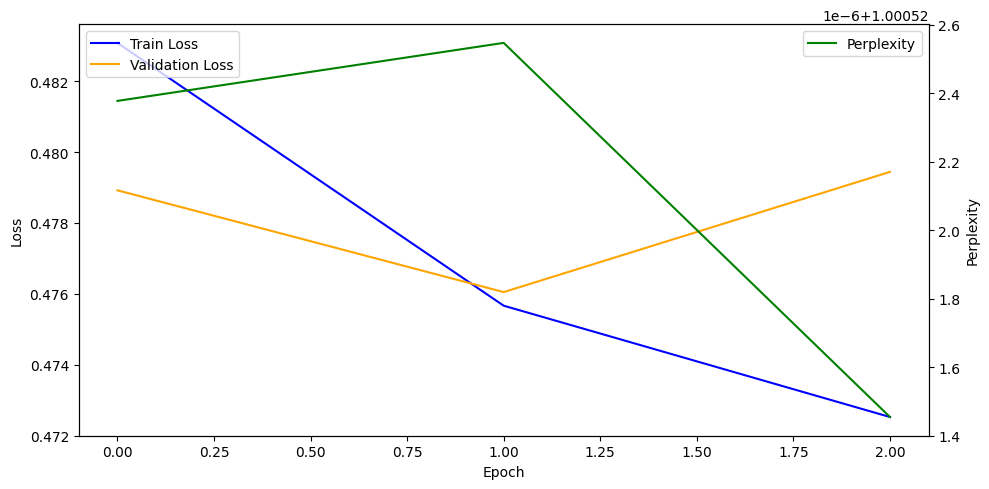

In [21]:
trainer.plot()